In [1]:
import cv2
import numpy as np
import torch
import torchvision.transforms as T
from torchvision.models.segmentation import deeplabv3_resnet101
import matplotlib.pyplot as plt

원본 강아지 이미지 크기: (1400, 1050, 3)
배경(사막) 이미지 크기: (598, 811, 3)


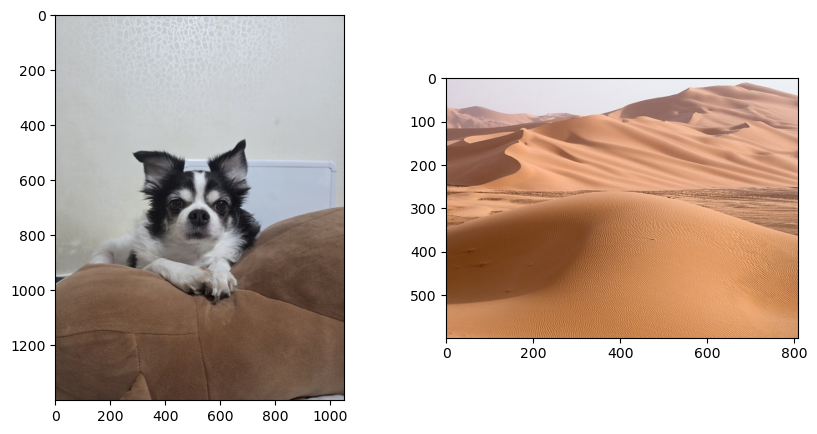

In [2]:
dog_img_path = "./images/image_dog02.jpg"
sand_img_path = "./images/image_desert.jpg"

dog_img = cv2.imread(dog_img_path)
sand_img = cv2.imread(sand_img_path)

dog_img = cv2.cvtColor(dog_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)

print(f"원본 강아지 이미지 크기: {dog_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(dog_img)

plt.subplot(1, 2, 2)
plt.imshow(sand_img)

plt.show()

In [3]:
model = deeplabv3_resnet101(pretrained=True).eval()

transform = T.Compose([
    T.ToPILImage(),
    T.Resize((520, 520)),  # 모델 입력 크기
    T.ToTensor(),
])

input_tensor = transform(dog_img).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

c:\Users\suhol\anaconda3\envs\cv_venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\suhol\anaconda3\envs\cv_venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


추론 마스크 크기 (Before Resize): (520, 520)


In [4]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(
    output_predictions, 
    (dog_img.shape[1], dog_img.shape[0]), 
    interpolation=cv2.INTER_NEAREST
    )

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (1400, 1050)


In [5]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [ 0 12]


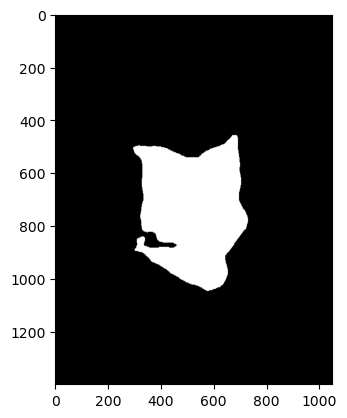

In [6]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

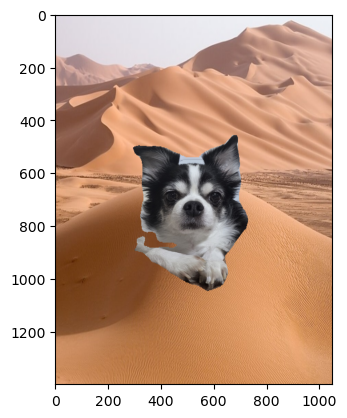

In [7]:
# 배경을 갱아쥐 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (dog_img.shape[1], dog_img.shape[0]))

# 갱아쥐 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, dog_img, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

# 문제점
- 피사체에 속하지 않는 배경까지 피사체의 일부로 인식
- 피사체의 일부를 배경으로 인식
- 즉, 정확도의 문제

# 해결방법
노드에서 소개해준 방법들 위주로..
- 적외선 카메라와 합성하여 사용(주변 배경에 비해 온도가 높은 지점 + 외형 -> person)
- 3D camera를 활용하여 focus point와 DOF 거리를 계산하여 어떻게 이러쿵저러쿵? 해보기
- 조리개가 조금 개방될 수록 심도가 얕아지는 것처럼, 이미지의 크기를 조절해보기

3번 방법으로 이미지를 crop 해보자 해보자

In [8]:
img_mask.shape

(1400, 1050)

In [9]:
row_pos = []
col_pos = []

for i, row in enumerate(img_mask):
    for j, pixel in enumerate(row):
        if pixel > 0:
            row_pos.append(i)
            col_pos.append(j)

y1, y2 = min(row_pos), max(row_pos)
x1, x2 = min(col_pos), max(col_pos)

print(f"y 최소 : {y1}, y 최대 : {y2}")
print(f"x 최소 : {x1}, x 최대 : {x2}")

y 최소 : 458, y 최대 : 1047
x 최소 : 295, x 최대 : 728


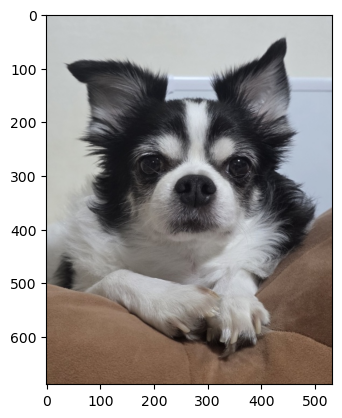

In [21]:
dog_img_resized = dog_img[y1-50:y2+50, x1-50:x2+50]

plt.imshow(dog_img_resized)
plt.show()

In [22]:
input_tensor = transform(dog_img_resized).unsqueeze(0)

with torch.no_grad():
    output = model(input_tensor)["out"][0]
    output_predictions = output.argmax(0).byte().cpu().numpy()

print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

추론 마스크 크기 (Before Resize): (520, 520)


In [23]:
# 마스크를 원본 크기로 Resize
output_predictions_resized = cv2.resize(
    output_predictions, 
    (dog_img_resized.shape[1], dog_img_resized.shape[0]), 
    interpolation=cv2.INTER_NEAREST
    )

print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

추론 마스크 크기 (After Resize): (689, 533)


In [24]:
unique_classes = np.unique(output_predictions_resized)
print(f"예측된 클래스 ID: {unique_classes}")

예측된 클래스 ID: [ 0 12]


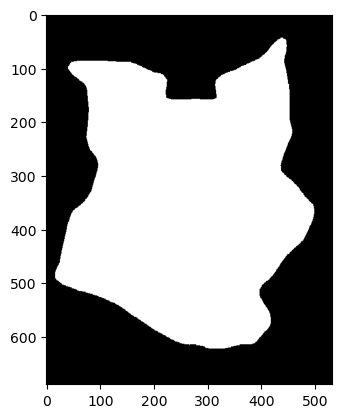

In [25]:
target_class_id = unique_classes[-1]

seg_map = (output_predictions_resized == target_class_id)
img_mask = seg_map.astype(np.uint8) * 255

plt.imshow(img_mask, cmap='gray')
plt.show()

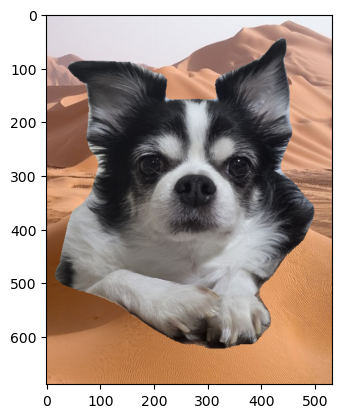

In [26]:
# 배경을 갱아쥐 이미지 크기에 맞춤
sand_img_resized = cv2.resize(sand_img, (dog_img_resized.shape[1], dog_img_resized.shape[0]))

# 갱아쥐 부분만 남기고 배경 적용
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)  # 3채널 변환
result_img = np.where(img_mask_color == 255, dog_img_resized, sand_img_resized)  # 마스크 기반 합성

plt.imshow(result_img)
plt.show()

오...! 일단 확실히 좋아지긴 했다...

찾아보니까, depth map을 통해 거리 기반 가중치를 설정하는 방법이 있다고 한다.  
나는 3d camera가 있어야만 피사체와의 거리, 피사체와 DOF의 거리 등을 구할 수 있다고 생각했는데,  
실제로는 2차원 이미지 공간에서 거리를 계산하는 다양한 모델들이 있다고 한다.  
- MiDaS, DPT, LeReS 와 같은 pretrained depth estimator로 depth map을 얻자
- 그 depth map을 segmentation에 함께 넣는다

우선 어떻게 사용하는 지 계속 찾아보고는 있는데... 일단 이 상태로 github에 올리고 다음에 고치도록 해야겠다